In [3]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text
import numpy as np

In [4]:

# Folder containing all .xls files
data_dir = "data sources"

# Seasons to include
years = range(2018, 2025)

# Container for all team offense data with postseason win flags
final_df_list = []

for year in years:
    print(f"Processing {year}...")

    # --- Load team offense file ---
    offense_path = os.path.join(data_dir, f"team-offense-{year}.xls")
    if not os.path.exists(offense_path):
        print(f"Offense file not found for {year}, skipping.")
        continue

    # Read with two header levels
    offense_df = pd.read_html(offense_path, header=[0, 1])[0]
    offense_df = offense_df.dropna(how="all").reset_index(drop=True)

    # --- Combine multi-level headers into readable names ---
    if isinstance(offense_df.columns, pd.MultiIndex):
        offense_df.columns = [
            f"{upper.strip()}_{lower.strip()}" if upper and upper != lower else lower.strip()
            for upper, lower in offense_df.columns
        ]
        # Clean up special cases like unnamed headers
        offense_df.columns = [
            col.replace("Unnamed: ", "")
               .replace("level_0_", "")
               .replace("__", "_")
               .strip("_")
            for col in offense_df.columns
        ]

    # --- Identify offense team column ---
    offense_team_col = None
    for col in offense_df.columns:
        # Catch columns like "Tm", "1_Tm", or "_Tm"
        if "tm" in col.lower():
            offense_team_col = col
            break

    if not offense_team_col:
        print(f"No team column found in offense data for {year}, skipping.")
        print("Detected columns:", offense_df.columns.tolist())
        continue

    # --- Load postseason file ---
    post_path = os.path.join(data_dir, f"{year}-postseason-teams.xls")
    if not os.path.exists(post_path):
        print(f"Postseason file not found for {year}, assuming no winners.")
        winners = []
    else:
        post_df = pd.read_html(post_path)[0]
        post_df = post_df.dropna(how="all").reset_index(drop=True)
        if isinstance(post_df.columns, pd.MultiIndex):
            post_df.columns = post_df.columns.droplevel(0)

        # --- Identify winner column ---
        winner_col = None
        for col in post_df.columns:
            if "winner" in col.lower():
                winner_col = col
                break

        if not winner_col:
            print(f"No 'winner' column found for {year}, assuming no winners.")
            winners = []
        else:
            winners = (
                post_df[winner_col]
                .astype(str)
                .str.replace(r"[\*\+]", "", regex=True)
                .str.strip()
                .unique()
            )

    # --- Clean offense team names ---
    cleaned_team_names = (
        offense_df[offense_team_col]
        .astype(str)
        .str.replace(r"[\*\+]", "", regex=True)
        .str.strip()
    )

    # --- Add postseason win flag ---
    offense_df["Won_Postseason_Game"] = cleaned_team_names.apply(
        lambda team: "Yes" if team in winners else "No"
    )

    # --- Add season column ---
    offense_df["Season"] = year

    # --- Store for final combination ---
    final_df_list.append(offense_df)

# --- Combine all seasons ---
if final_df_list:
    final_df = pd.concat(final_df_list, ignore_index=True)
    output_path = os.path.join(data_dir, "combined_team_offense_with_postseason_flag.csv")
    final_df.to_csv(output_path, index=False)
    print(f"\nCombined team offense data saved to {output_path}")
else:
    print("\nNo data combined. Check file names and column labels.")


Processing 2018...
Processing 2019...
Processing 2020...
Processing 2021...
Processing 2022...
Processing 2023...
Processing 2024...

Combined team offense data saved to data sources\combined_team_offense_with_postseason_flag.csv


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


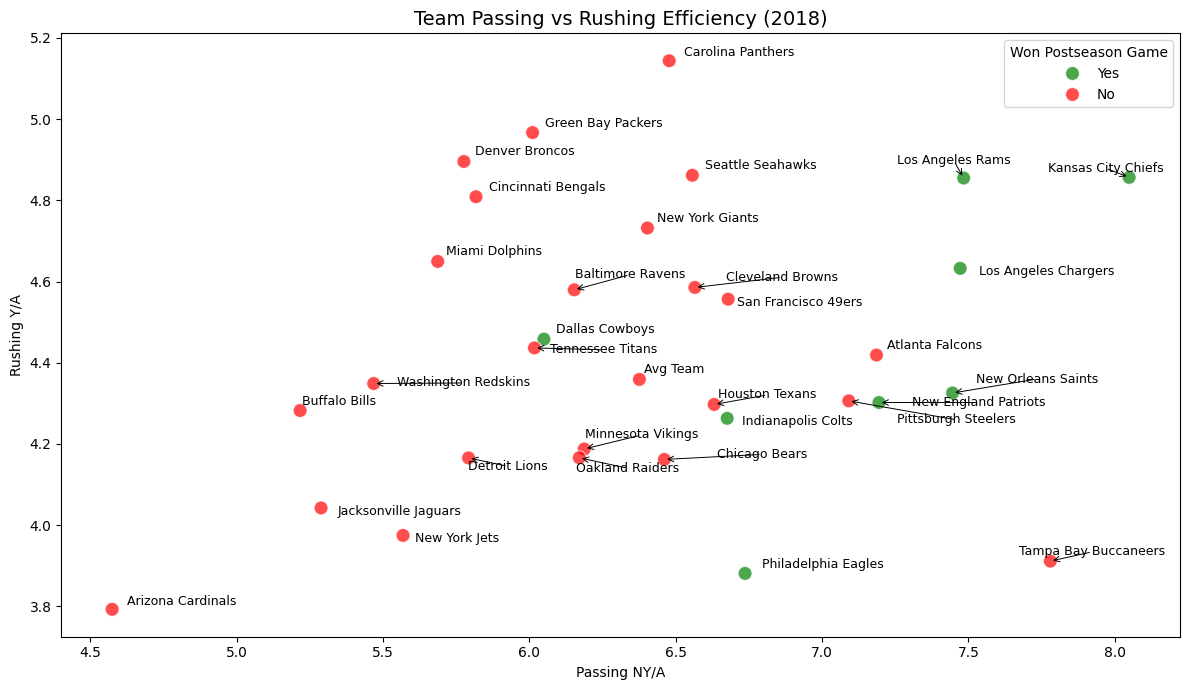

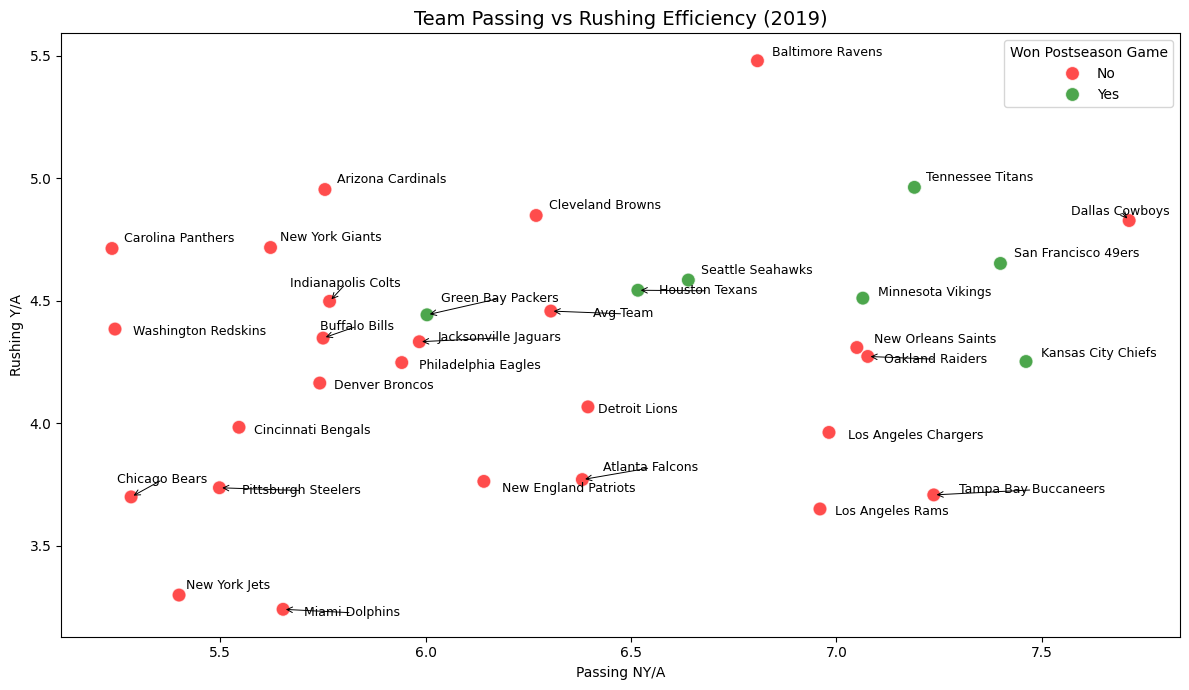

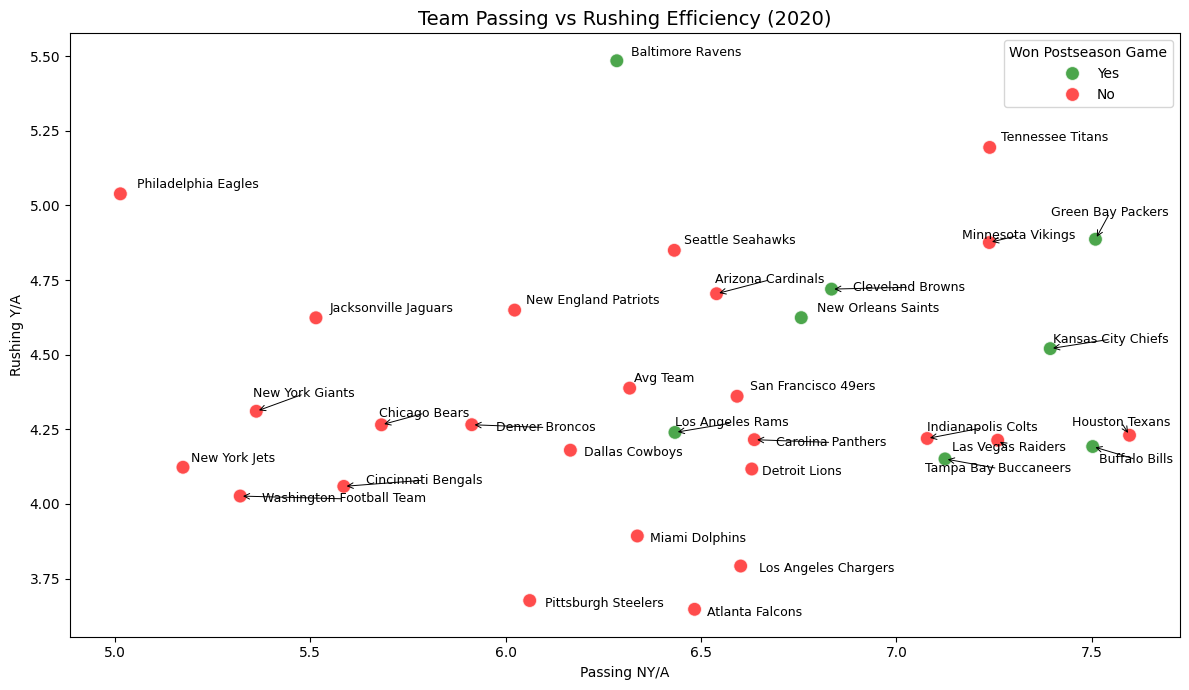

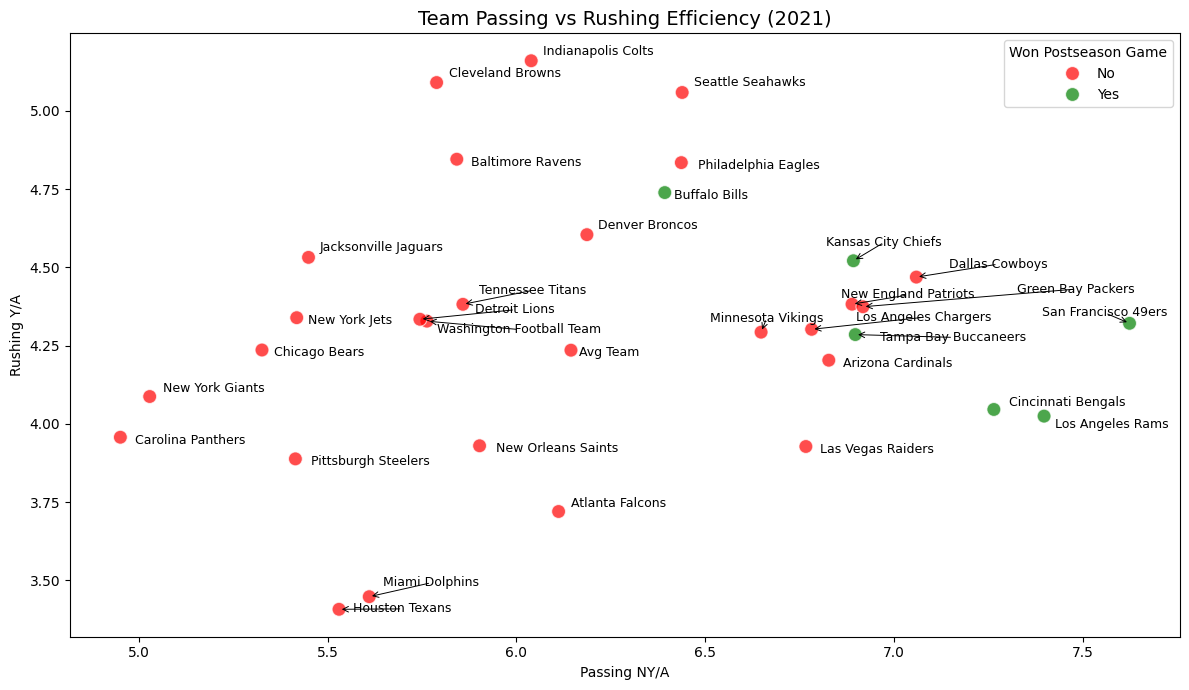

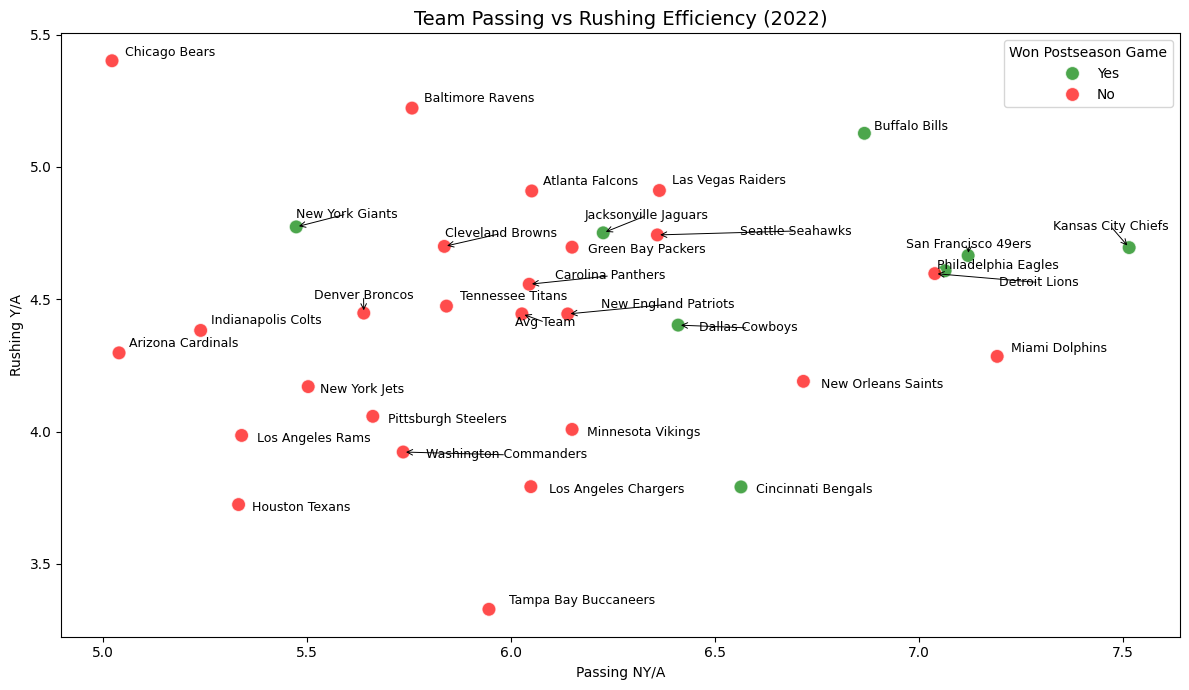

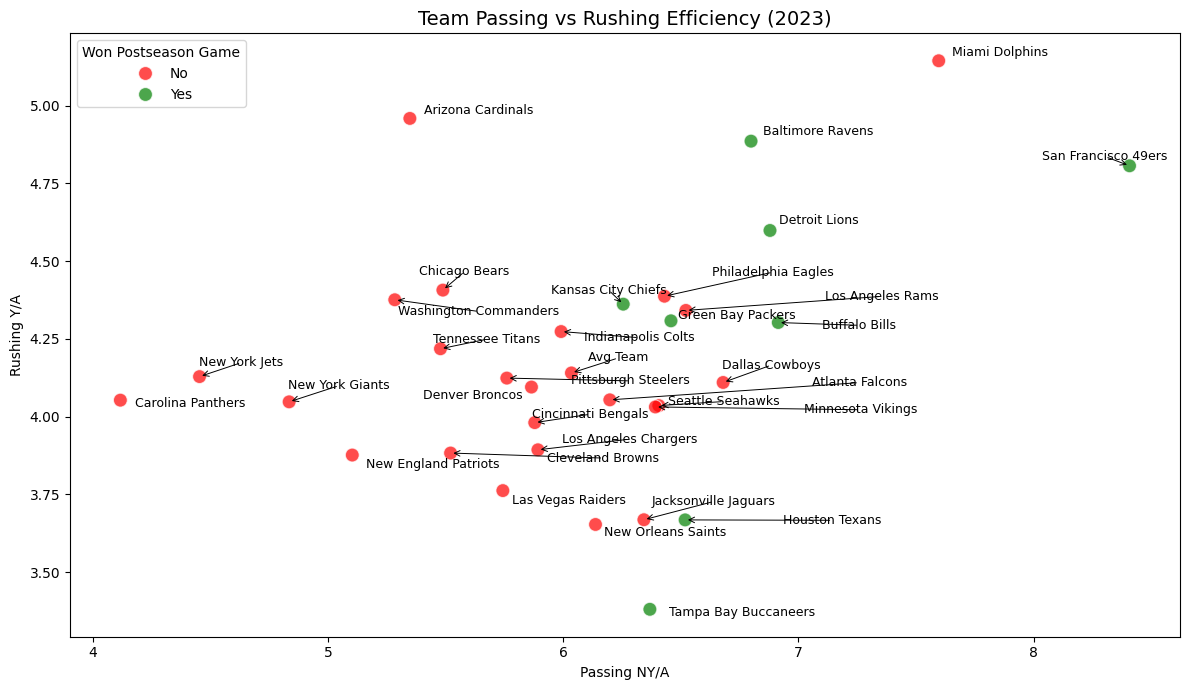

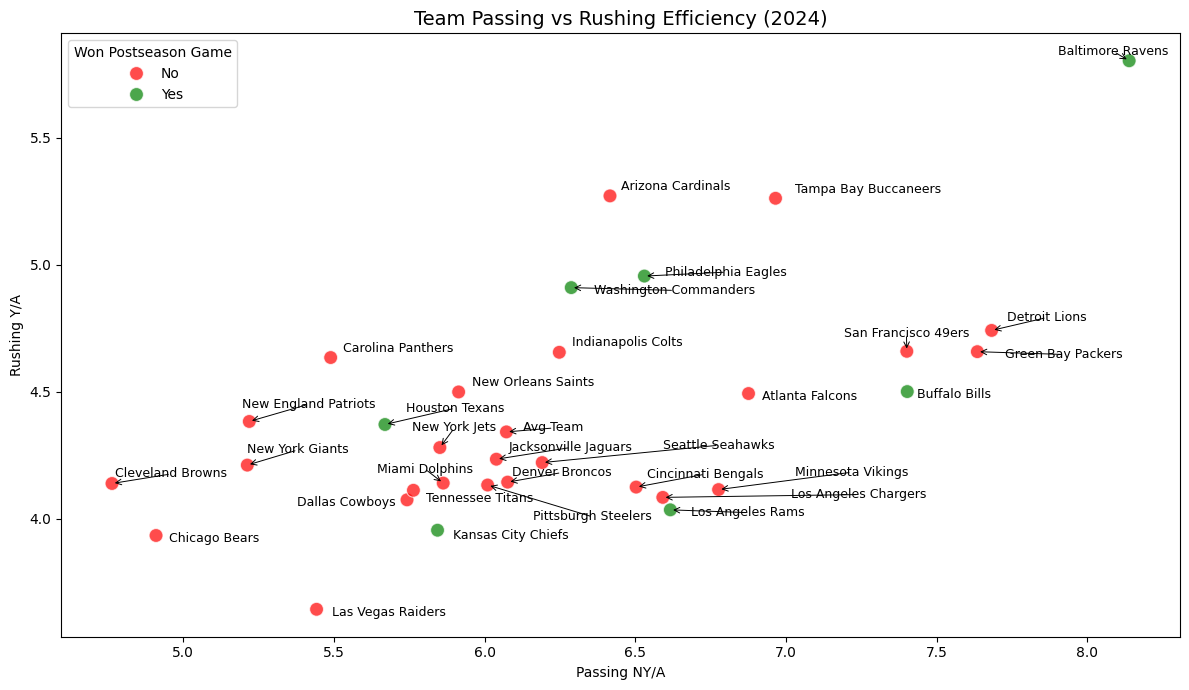

In [5]:
# Load combined CSV
data_path = "data sources/combined_team_offense_with_postseason_flag.csv"
df = pd.read_csv(data_path)

# Ensure numeric columns are numeric
df["Passing_NY/A"] = pd.to_numeric(df["Passing_NY/A"], errors="coerce")
df["Rushing_Y/A"] = pd.to_numeric(df["Rushing_Y/A"], errors="coerce")

# Get unique seasons
seasons = df["Season"].unique()

for season in seasons:
    season_df = df[df["Season"] == season].copy()

    # Drop unwanted summary rows but keep "Avg team point"
    season_df = season_df[~season_df["1_Tm"].isin(["League Total", "Avg Tm/G"])].reset_index(drop=True)

    # Add jitter
    x_jitter = np.random.normal(0, 0.05, size=len(season_df))
    y_jitter = np.random.normal(0, 0.05, size=len(season_df))

    plt.figure(figsize=(12, 7))
    sns.scatterplot(
        x=season_df["Passing_NY/A"] + x_jitter,
        y=season_df["Rushing_Y/A"] + y_jitter,
        hue=season_df["Won_Postseason_Game"],
        palette={"Yes": "green", "No": "red"},
        s=100,
        alpha=0.7
    )

    # Annotate team names with adjust_text
    texts = []
    for i, row in season_df.iterrows():
        texts.append(
            plt.text(
                row["Passing_NY/A"] + x_jitter[i],
                row["Rushing_Y/A"] + y_jitter[i],
                row["1_Tm"],
                fontsize=9
            )
        )

    adjust_text(
        texts,
        arrowprops=dict(arrowstyle="->", color='black', lw=0.7),
        expand_text=(1.2, 1.2)
    )

    plt.title(f"Team Passing vs Rushing Efficiency ({season})", fontsize=14)
    plt.xlabel("Passing NY/A")
    plt.ylabel("Rushing Y/A")
    plt.legend(title="Won Postseason Game")
    plt.tight_layout()
    plt.show()

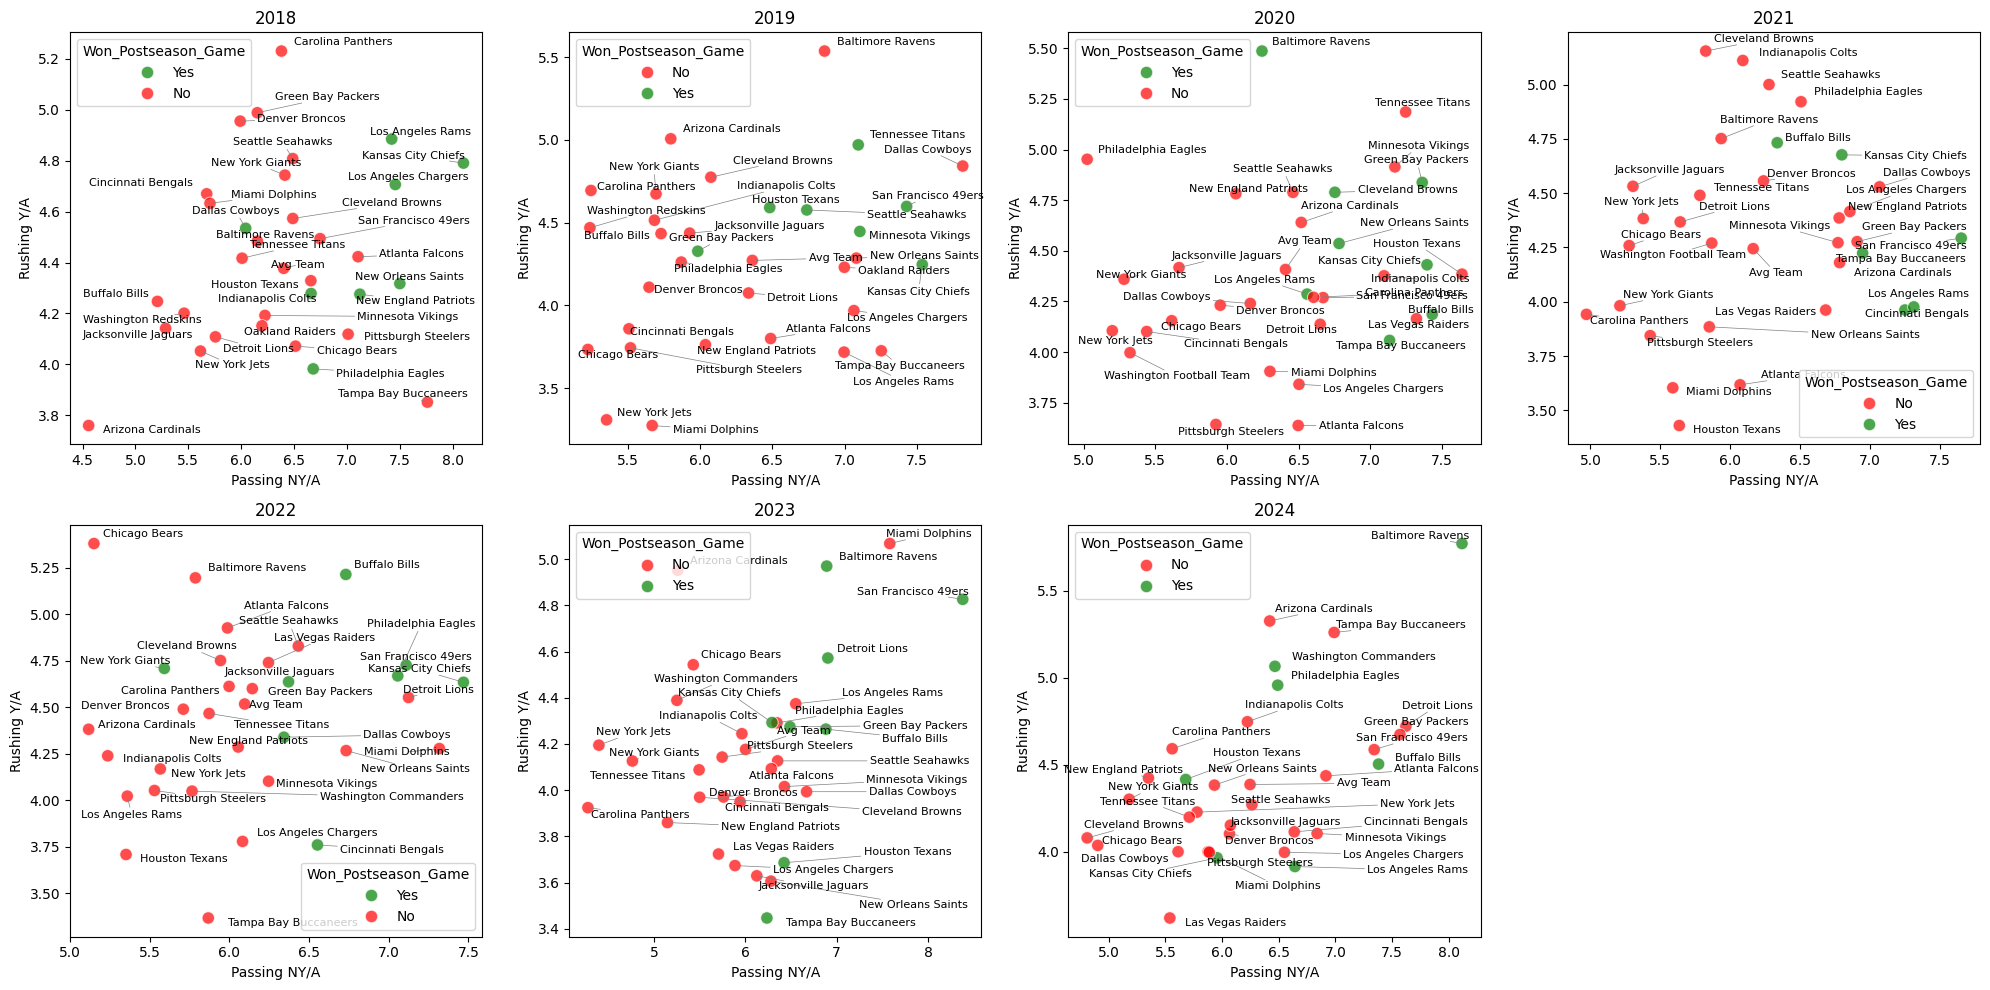

In [6]:
# Load data
data_path = "data sources/combined_team_offense_with_postseason_flag.csv"
df = pd.read_csv(data_path)
df["Passing_NY/A"] = pd.to_numeric(df["Passing_NY/A"], errors="coerce")
df["Rushing_Y/A"] = pd.to_numeric(df["Rushing_Y/A"], errors="coerce")

seasons = sorted(df["Season"].unique())

# Determine grid size (e.g., 2 rows x 4 columns)
n_cols = 4
n_rows = int(np.ceil(len(seasons)/n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*5), sharex=False, sharey=False)
axes = axes.flatten()

for i, season in enumerate(seasons):
    ax = axes[i]
    season_df = df[df["Season"] == season].copy()
    season_df = season_df[~season_df["1_Tm"].isin(["League Total", "Avg Tm/G"])].reset_index(drop=True)

    # Add jitter
    x_jitter = np.random.normal(0, 0.05, size=len(season_df))
    y_jitter = np.random.normal(0, 0.05, size=len(season_df))

    # Scatter
    sns.scatterplot(
        x=season_df["Passing_NY/A"] + x_jitter,
        y=season_df["Rushing_Y/A"] + y_jitter,
        hue=season_df["Won_Postseason_Game"],
        palette={"Yes": "green", "No": "red"},
        s=80,
        alpha=0.7,
        ax=ax
    )

    # Annotate team names
    texts = []
    for j, row in season_df.iterrows():
        texts.append(
            ax.text(
                row["Passing_NY/A"] + x_jitter[j],
                row["Rushing_Y/A"] + y_jitter[j],
                row["1_Tm"],
                fontsize=8
            )
        )
    adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="->", color='gray', lw=0.5))

    ax.set_title(f"{season}")
    ax.set_xlabel("Passing NY/A")
    ax.set_ylabel("Rushing Y/A")

# Hide empty subplots if any
for k in range(i+1, len(axes)):
    axes[k].axis('off')

plt.tight_layout()
plt.show()

In [7]:
# Container for summary results
results = []

# Get unique seasons
seasons = sorted(df["Season"].unique())

for season in seasons:
    season_df = df[df["Season"] == season]

    # Get the average team values for this season
    avg_row = season_df[season_df["1_Tm"] == "Avg Team"].iloc[0]
    avg_pass = avg_row["Passing_NY/A"]
    avg_rush = avg_row["Rushing_Y/A"]

    # Filter for postseason winners
    winners_df = season_df[season_df["Won_Postseason_Game"] == "Yes"]

    # Classify each winner
    def category(row):
        pass_above = row["Passing_NY/A"] > avg_pass
        rush_above = row["Rushing_Y/A"] > avg_rush
        if pass_above and rush_above:
            return "Both"
        elif pass_above:
            return "Passing"
        elif rush_above:
            return "Rushing"
        else:
            return "Neither"

    winners_df["Above_Avg_Category"] = winners_df.apply(category, axis=1)

    # Count each category
    summary = winners_df["Above_Avg_Category"].value_counts().to_dict()
    summary["Season"] = season
    summary["Postseason_Winners"] = winners_df.shape[0]

    results.append(summary)

# Create DataFrame and fill missing categories with 0
eda_df = pd.DataFrame(results).fillna(0)

# Convert relevant columns to integers
for col in ["Both", "Passing", "Rushing", "Neither", "Postseason_Winners"]:
    eda_df[col] = eda_df[col].astype(int)

# Reorder columns
eda_df = eda_df[["Season", "Postseason_Winners", "Both", "Passing", "Rushing", "Neither"]]

print(eda_df)

   Season  Postseason_Winners  Both  Passing  Rushing  Neither
0    2018                   8     3        4        1        0
1    2019                   7     5        1        1        0
2    2020                   8     4        3        1        0
3    2021                   6     2        4        0        0
4    2022                   8     5        2        1        0
5    2023                   8     6        2        0        0
6    2024                   7     4        1        0        2


C:\Users\coole\AppData\Local\Temp\ipykernel_29800\1292505113.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winners_df["Above_Avg_Category"] = winners_df.apply(category, axis=1)
C:\Users\coole\AppData\Local\Temp\ipykernel_29800\1292505113.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winners_df["Above_Avg_Category"] = winners_df.apply(category, axis=1)
C:\Users\coole\AppData\Local\Temp\ipykernel_29800\1292505113.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [8]:
overall_corr = df[["Passing_NY/A", "Rushing_Y/A"]].corr().iloc[0,1]
print(f"Overall correlation between Passing NY/A and Rushing Y/A: {overall_corr:.2f}")

seasons = df["Season"].unique()

for season in seasons:
    season_df = df[df["Season"] == season]
    corr = season_df[["Passing_NY/A", "Rushing_Y/A"]].corr().iloc[0,1]
    print(f"Season {season}: correlation = {corr:.2f}")

Overall correlation between Passing NY/A and Rushing Y/A: 0.28
Season 2018: correlation = 0.23
Season 2019: correlation = 0.27
Season 2020: correlation = 0.15
Season 2021: correlation = 0.13
Season 2022: correlation = 0.15
Season 2023: correlation = 0.33
Season 2024: correlation = 0.58


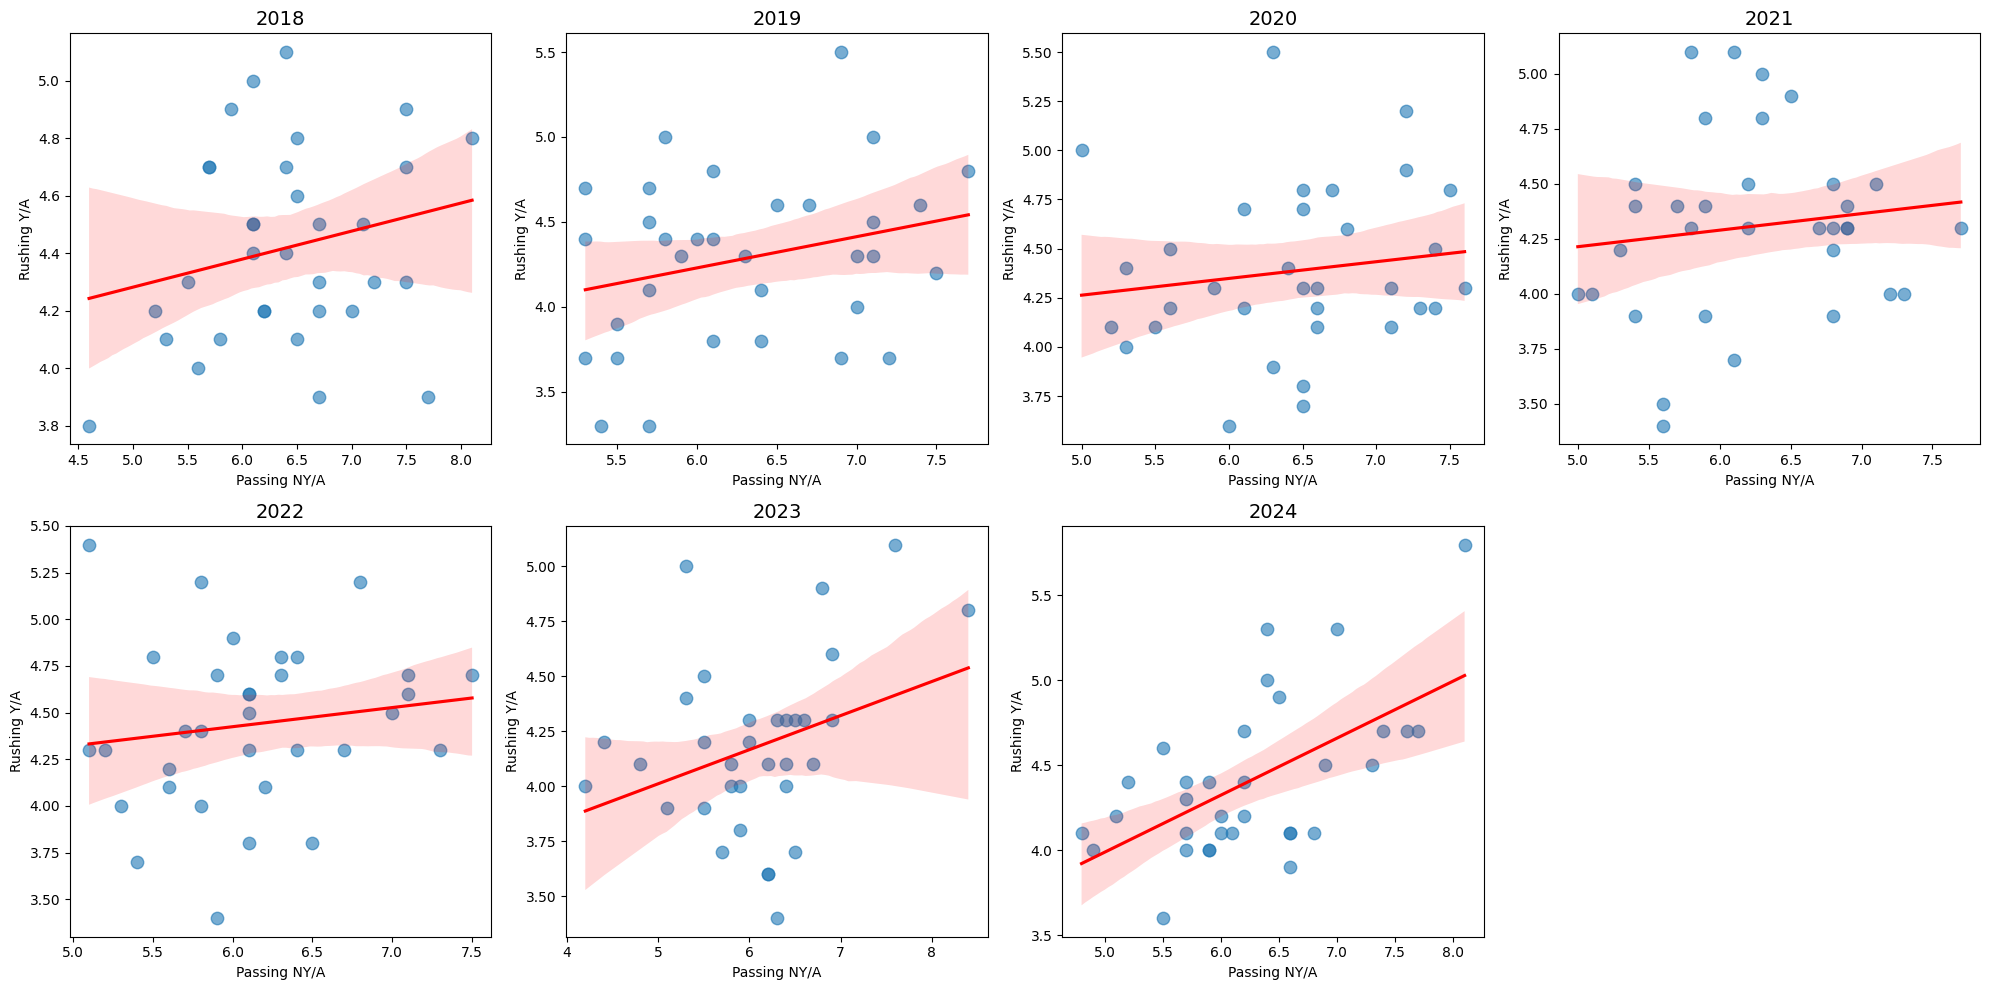

In [9]:
seasons = sorted(df["Season"].unique())

# Grid size
n_cols = 4
n_rows = int(np.ceil(len(seasons)/n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*5), sharex=False, sharey=False)
axes = axes.flatten()

for i, season in enumerate(seasons):
    ax = axes[i]
    season_df = df[df["Season"] == season].copy()
    season_df = season_df[~season_df["1_Tm"].isin(["League Total", "Avg Tm/G"])].reset_index(drop=True)

    # Regression plot
    sns.regplot(
        data=season_df,
        x="Passing_NY/A",
        y="Rushing_Y/A",
        scatter_kws={'s':80, 'alpha':0.6},
        line_kws={'color':'red'},
        ax=ax
    )

    ax.set_title(f"{season}", fontsize=14)
    ax.set_xlabel("Passing NY/A")
    ax.set_ylabel("Rushing Y/A")

# Hide any empty subplots
for k in range(i+1, len(axes)):
    axes[k].axis('off')

plt.tight_layout()
plt.show()

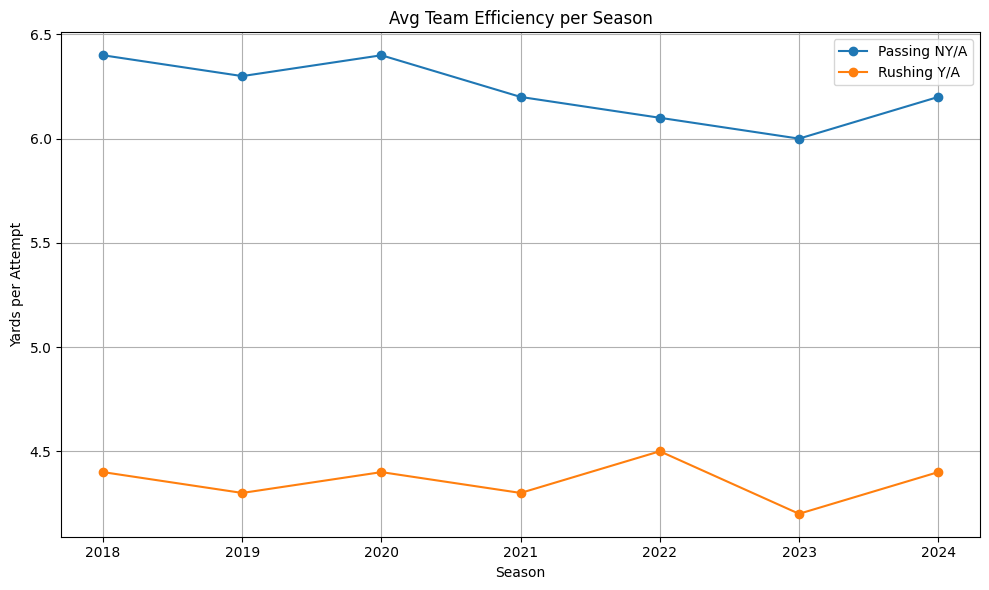

In [10]:
avg_team_df = df[df["1_Tm"] == "Avg Team"]

# Plot
plt.figure(figsize=(10,6))
plt.plot(avg_team_df["Season"], avg_team_df["Passing_NY/A"], marker='o', label="Passing NY/A")
plt.plot(avg_team_df["Season"], avg_team_df["Rushing_Y/A"], marker='o', label="Rushing Y/A")

plt.title("Avg Team Efficiency per Season")
plt.xlabel("Season")
plt.ylabel("Yards per Attempt")
plt.xticks(avg_team_df["Season"])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
df_clean = df[~df["1_Tm"].isin(["League Total", "Avg Tm/G", "Avg Team"])].copy()

# Summary stats per season
season_stats = df_clean.groupby("Season")[["Passing_NY/A", "Rushing_Y/A"]].describe()
print("Summary statistics per season:\n")
print(season_stats)

# Summary stats across all seasons
overall_stats = df_clean[["Passing_NY/A", "Rushing_Y/A"]].describe()
print("\nSummary statistics across all seasons:\n")
print(overall_stats)

Summary statistics per season:

       Passing_NY/A                                                    \
              count      mean       std  min    25%   50%    75%  max   
Season                                                                  
2018           32.0  6.400000  0.792302  4.6  5.875  6.40  6.775  8.1   
2019           32.0  6.306250  0.733061  5.3  5.700  6.10  7.000  7.7   
2020           32.0  6.431250  0.732401  5.0  5.975  6.50  7.100  7.6   
2021           32.0  6.225000  0.706650  5.0  5.675  6.15  6.800  7.7   
2022           32.0  6.115625  0.642630  5.1  5.675  6.10  6.425  7.5   
2023           32.0  6.062500  0.852983  4.2  5.500  6.20  6.500  8.4   
2024           32.0  6.246875  0.817938  4.8  5.700  6.15  6.650  8.1   

       Rushing_Y/A                                                  
             count      mean       std  min    25%   50%  75%  max  
Season                                                              
2018          32.0  4.418750  